# Stochastic Depth
### Reference
1. [Deep Networks with Stochastic Depth](https://arxiv.org/abs/1603.09382)

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import callbacks
from tensorflow.keras import backend
import matplotlib.pyplot as plt

## Survival probability

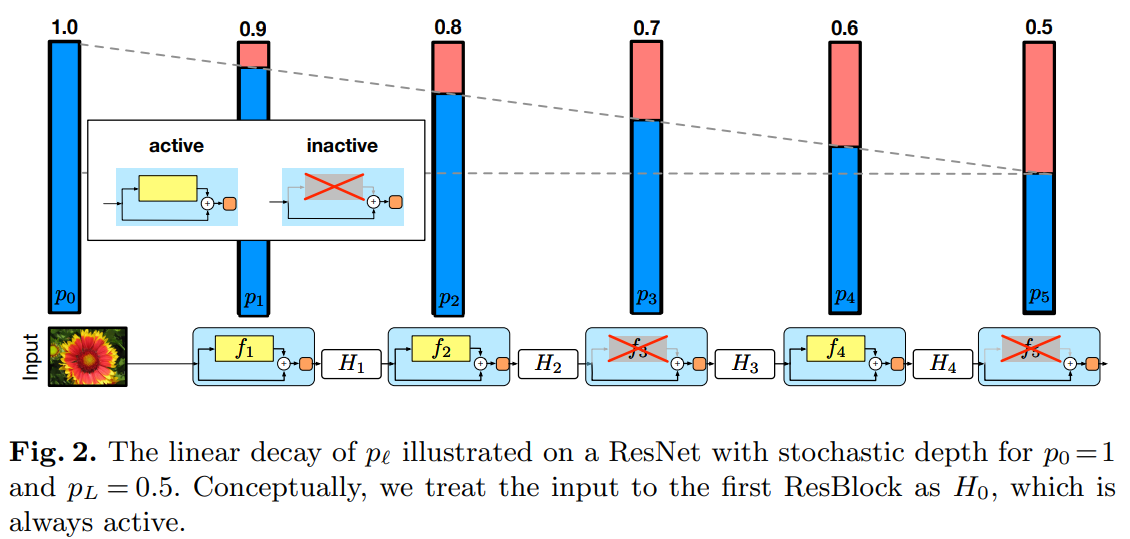

## Survival Probability Decay

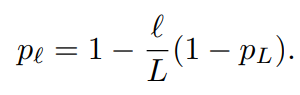

In [ ]:
def get_rate(lowest_rate, curr_block, num_block):
    return 1 - (1 - lowest_rate) * curr_block / num_block

for i in range(1, 10):
  print(get_rate(0.5, i, 9))

0.9444444444444444
0.8888888888888888
0.8333333333333334
0.7777777777777778
0.7222222222222222
0.6666666666666667
0.6111111111111112
0.5555555555555556
0.5


### Its effect

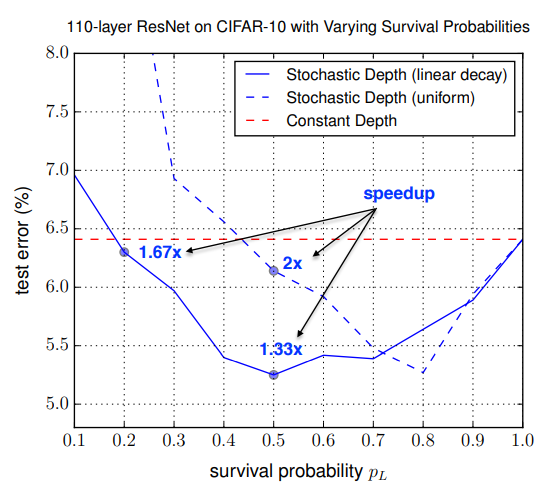

## Model building

In [2]:
def resblock(inputs, filter, args, stage, block, rate=None):
  x = layers.BatchNormalization()(inputs)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=filter,
                    kernel_size=(3, 3),
                    strides=(1 ,1) if stage == 0 or block > 0 else (2, 2),
                    padding='same',
                    kernel_initializer=args.initializer,
                    kernel_regularizer=args.regularizer)(x)
  
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=filter,
                    kernel_size=(3, 3),
                    strides=(1 ,1),
                    padding='same',
                    kernel_initializer=args.initializer,
                    kernel_regularizer=args.regularizer)(x)

  if rate:
    x = layers.Dropout(rate=rate, noise_shape=(None, 1, 1, 1))(x)

  if stage == 0 or block > 0:
    out = layers.Add()([x, inputs])
    return out
  else:
    id = layers.Conv2D(filters=filter,
                       kernel_size=(1, 1),
                       strides=(2, 2),
                       padding='same',
                       kernel_initializer=args.initializer,
                       kernel_regularizer=args.regularizer)(inputs)
    out = layers.Add()([x, id])
    return out

In [38]:
def resnet20(inputs, args):
  def get_rate(lowest_rate, curr_block, num_block):
    return (1 - lowest_rate) * curr_block / num_block                    

  x = layers.Conv2D(filters=args.filters[0],
                    kernel_size=(3, 3),
                    strides=(1, 1),
                    padding='same',
                    kernel_initializer=args.initializer,
                    kernel_regularizer=args.regularizer)(inputs)

  blocks = args.blocks * len(args.filters)
  block_idx = 1
  for stage, filter in enumerate(args.filters):
    for block in range(args.blocks):
      rate = get_rate(1-args.drop_out, block_idx, blocks)
      x = resblock(x, filter, args, stage, block, rate)
      print(f'{stage+2}-{block+1} size{x.shape}')
      block_idx += 1

  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(units=10,
                   activation='softmax')(x)
  return x  

In [4]:
def get_model(args):
  inputs = layers.Input(shape=args.input_size)
  outputs = resnet20(inputs, args)
  model = models.Model(inputs=inputs, outputs=outputs)
  return model

In [34]:
class Config:
  epochs = 50
  lr = 1e-2
  momentum = 0.9
  batch_size = 128
  validation_split = 0.1
  weight_decay = 1e-4
  input_size = (32, 32, 3)
  filters = [16, 32, 64]
  blocks = 3
  drop_out= 0.36
  loss = losses.SparseCategoricalCrossentropy(from_logits=False)
  metric = metrics.SparseCategoricalAccuracy()
  optimizer = optimizers.SGD(learning_rate=lr, momentum=momentum)
  initializer= initializers.HeNormal()
  regularizer = regularizers.L2(weight_decay)

In [21]:
model = get_model(Config)

2-1 size(None, 32, 32, 16)
2-2 size(None, 32, 32, 16)
2-3 size(None, 32, 32, 16)
3-1 size(None, 16, 16, 32)
3-2 size(None, 16, 16, 32)
3-3 size(None, 16, 16, 32)
4-1 size(None, 8, 8, 64)
4-2 size(None, 8, 8, 64)
4-3 size(None, 8, 8, 64)


In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 32, 32, 16)   0           ['batch_normalization[0][0]']

## Preprocessing and data augmentation

In [8]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 11s 0us/step


In [9]:
def input_pipeline(feature, label, validation_split, batch_size, pad=4):
  N, H, W, C =  feature.shape
  ds = tf.data.Dataset.from_tensor_slices((feature, label))
  ds = ds.map(lambda x, y: (tf.cast(x, tf.float32), y))
  ds = ds.map(lambda x, y: (tf.divide(x, 255.), y))
  ds = ds.map(lambda x, y: (tf.divide(tf.subtract(x, tf.math.reduce_mean(x)), tf.math.reduce_std(x)), y))
  ds = ds.shuffle(1000)
  ds = ds.cache()

  if validation_split:
    n_val = int(N * validation_split)
    val_ds = ds.take(n_val)
    train_ds = ds.skip(n_val)
  
  crop = train_ds.map(lambda x, y: (tf.image.resize_with_pad(x, H+pad*2, W+pad*2), y))
  crop = crop.map(lambda x, y: (tf.image.random_crop(x, (H, W, C)), y))
  h_flip = train_ds.map(lambda x, y: (tf.image.random_flip_up_down(x), y))
  train_ds = train_ds.concatenate(crop)
  train_ds = train_ds.concatenate(h_flip)
  train_ds = train_ds.shuffle(1000)
  train_ds = train_ds.cache()

  train_ds = train_ds.batch(batch_size=batch_size, drop_remainder=True)
  val_ds = val_ds.batch(batch_size=batch_size, drop_remainder=True)
  print(f'train_iteration: {train_ds.cardinality()}       val_iteration: {val_ds.cardinality()}')
  train_ds = train_ds.prefetch(1)
  val_ds = val_ds.prefetch(1)

  return train_ds, val_ds

In [10]:
train_ds, val_ds = input_pipeline(x_train, y_train, Config.validation_split, Config.batch_size)

train_iteration: 1054       val_iteration: 39


## Model training

In [22]:
model.load_weights(filepath='stochastic_depth.h5')

In [23]:
model.compile(optimizer=Config.optimizer,
              loss=Config.loss,
              metrics=Config.metric)

In [24]:
model.fit(x=train_ds,
          validation_data=val_ds,
          epochs=5,)

Epoch 1/5
1054/1054 [==============================] - 1748s 2s/step - loss: 1.1286 - sparse_categorical_accuracy: 0.6451 - val_loss: 1.2554 - val_sparse_categorical_accuracy: 0.5944
Epoch 2/5
1054/1054 [==============================] - 1679s 2s/step - loss: 1.0921 - sparse_categorical_accuracy: 0.6601 - val_loss: 1.1359 - val_sparse_categorical_accuracy: 0.6406
Epoch 3/5
1054/1054 [==============================] - 1782s 2s/step - loss: 1.0607 - sparse_categorical_accuracy: 0.6711 - val_loss: 1.1570 - val_sparse_categorical_accuracy: 0.6256
Epoch 4/5
1054/1054 [==============================] - 1798s 2s/step - loss: 1.0349 - sparse_categorical_accuracy: 0.6795 - val_loss: 1.0640 - val_sparse_categorical_accuracy: 0.6639
Epoch 5/5
1054/1054 [==============================] - 1816s 2s/step - loss: 1.0149 - sparse_categorical_accuracy: 0.6866 - val_loss: 1.0678 - val_sparse_categorical_accuracy: 0.6631


In [26]:
model.save('stochastic_depth.h5')

In [39]:
model2 = get_model(Config)

2-1 size(None, 32, 32, 16)
2-2 size(None, 32, 32, 16)
2-3 size(None, 32, 32, 16)
3-1 size(None, 16, 16, 32)
3-2 size(None, 16, 16, 32)
3-3 size(None, 16, 16, 32)
4-1 size(None, 8, 8, 64)
4-2 size(None, 8, 8, 64)
4-3 size(None, 8, 8, 64)


In [40]:
model2.compile(optimizer=Config.optimizer,
               loss=Config.loss,
               metrics=Config.metric)

In [ ]:
class DecayHelper(callbacks.Callback):
  def __init__(self, init_lr:float, decay_rate:float, patiance:int=6):
    self.init_lr = init_lr
    self.decay_rate = decay_rate
    self.patiance = patiance
    self.wait = 0
    self.best_accuracy = None
    self.best_weight = None
    self.best_epoch = None
    self.curr_lr = None

  def on_train_begin(self, logs=None):
    if not hasattr(self.model.optimizer.lr, 'lr'):
      backend.set_value(self.model.optimizer.lr, self.init_lr)
    if self.init_lr:
      self.curr_lr = self.init_lr

  def on_epoch_end(self, epoch, logs=None):
    curr_acc = logs.get('val_sparse_categorical_accuracy')
    if self.best_accuracy is None:
      self.best_accuracy = curr_acc
      self.best_weight = self.model.get_weigths()
      self.best_epoch = epoch
      self.wait = 0
    if tf.math.less(curr_acc, self.best_accuracy):
      self.wait += 1
      if tf.math.equal(self.wait, self.patiance):
        self.curr_lr *= self.decay_rate
        backend.set_value(self.model.optimizer.lr, self.curr_lr)
        tf.print(f'LR is updated by {self.curr_lr}', end='\n')
        
  def on_trian_end(self, logs=None):
    self.model.set_weights(self.best_weight)
    print(f'Training is terminated with best accuracy ',
          f'{self.best_accuracy} at epoch {self.best_epoch+1}')

In [42]:
model2.fit(x=train_ds,
           validation_data=val_ds,
           epochs=7,)

Epoch 1/7
1054/1054 [==============================] - 1876s 2s/step - loss: 1.1164 - sparse_categorical_accuracy: 0.6550 - val_loss: 1.0728 - val_sparse_categorical_accuracy: 0.6621
Epoch 2/7
1054/1054 [==============================] - 1769s 2s/step - loss: 1.0706 - sparse_categorical_accuracy: 0.6699 - val_loss: 1.0126 - val_sparse_categorical_accuracy: 0.6911
Epoch 3/7
1054/1054 [==============================] - 1751s 2s/step - loss: 1.0315 - sparse_categorical_accuracy: 0.6833 - val_loss: 0.9652 - val_sparse_categorical_accuracy: 0.7031
Epoch 4/7
1054/1054 [==============================] - 1744s 2s/step - loss: 0.9980 - sparse_categorical_accuracy: 0.6949 - val_loss: 0.9867 - val_sparse_categorical_accuracy: 0.6931
Epoch 5/7
1054/1054 [==============================] - 1729s 2s/step - loss: 0.9675 - sparse_categorical_accuracy: 0.7040 - val_loss: 0.9377 - val_sparse_categorical_accuracy: 0.7206
Epoch 6/7
1054/1054 [==============================] - 1706s 2s/step - loss: 0.9427 -

In [43]:
model2.save('stochastic_depth_036.h5')